In [1]:
# This is basically all you need for numerics:
import numpy as np
import scipy as sp

# Initializing a random seed:
rng = np.random.default_rng(seed=1234)

# These are some plotting packages:
## Basic plotting
import matplotlib.pyplot as plt
## Intermediate plotting
import seaborn as sns

# This is kinda nice to have
from tqdm.notebook import tqdm

# Putting some of the set-up in a different file:
from AlgorithmScripts import Big_matrix

In [2]:
def round(v, eigenvec_abs, conditioning):

    if (conditioning):
        return np.sign(v)
  
    v = np.sign(v) * eigenvec_abs
    
    return v
 
"""
Rounds the output vector to match the magnitude assumptions.
I made this as hard as possible the first time:
# if np.abs((v[i] - eigenvec_abs[i])) < np.abs((v[i] + eigenvec_abs[i])):
#   v[i] = eigenvec_abs[i]
# else:
#   v[i] = -eigenvec_abs[i]
"""

'\nRounds the output vector to match the magnitude assumptions.\nI made this as hard as possible the first time:\n# if np.abs((v[i] - eigenvec_abs[i])) < np.abs((v[i] + eigenvec_abs[i])):\n#   v[i] = eigenvec_abs[i]\n# else:\n#   v[i] = -eigenvec_abs[i]\n'

In [3]:
# This is one way to generate a problem, Idk if its the best way to make these 
# problems (our choice of how to do this matters)
def generate_problem(d: int, k: int):
    """
    Returns a eigenvector phase retrieval problem:
    - a Big_matrix instance
    - an eigenvalue of the instance
    - the absolute value of the entries of the eigenvector of that eigenvalue
    """
    #d is size of matrix, k is which eigenvector we want from the array of eigenvectors
    #in our model, this is harder when k is closer to d/2, k = 0 or k = d is easiest
    assert k < d
    #not <= bc of 0 indexing

    A = rng.normal(size=(d, d))
    A[0,0] = 50
    S = A

    big_matrix = Big_matrix(S)
    w, V = np.linalg.eig(S)
    v_abs = np.abs(V[:, k])
    ell = w[k]
    epsilon = np.sign(V[:, k])

    B = S - ell * np.eye(d)

    v_init = rng.normal(size=d)

    return v_init, big_matrix, ell, v_abs, epsilon





In [4]:
def project(v, w):
    """
    This function should return the projection of `v` onto the span of `w`.
    """
    proj_w_v = np.dot(v, w)/(np.dot(w, w)) * w
    
    return proj_w_v

In [5]:
def project_onto_orthogonal_subspace(v, w, proj_strength):
    proj = v - project(v, w)
    final = v*(1-proj_strength) + proj*(proj_strength)
    return final

In [6]:
def K_step(eigenvec_abs, v, ell, M, i, conditioning, proj_strength):
    """
    Returns the projection of `v` onto the orthogonal space of the the `i`th row
    of B (or C if conditioning is on)
    ell (l) is the eigenvalue
    """
    d = len(v)
    #i = i%d (old way)
    i = np.random.choice(d)
    #picks a random number from a 1D array created like np.arange(d)
    w = M.get_row(i)-(ell*((np.eye(d))[i, :]))

    if conditioning: 
        B_row_i = w
        B_row_i = w * eigenvec_abs / eigenvec_abs[i]
        w = B_row_i


    v = project_onto_orthogonal_subspace(v, w, proj_strength)

    return v

In [7]:
def K_algorithm(v_init, M, ell, eigenvec_abs, epsilon, n_iter, rounding_freq, conditioning, random_rounding, proj_strength):
    """
    Applies the K. algorithm to the initial vector `v_init` with the `Big_matrix`
    for `n_iter` steps.
    """
    v = v_init
    #tqdm is a progress bar
    #np.arange basically range creates list of 0 - 9 (if n_iter is 10)

    for i in np.arange(n_iter):
        v = K_step(eigenvec_abs, v, ell, M, i, conditioning, proj_strength)
        #we check if we're finished every 10 steps
        if i%10 == 0:
            if score(v, epsilon) == 1.0: 
                return v, i
        #-1 turns off rounding altogether
        if (random_rounding):
            if (rounding_freq >= 0):
                if (rng.random() < rounding_freq):
                    v = round(v, eigenvec_abs, conditioning)  
        else:
            if (rounding_freq >= 0):
                if (i%(int(rounding_freq*n_iter)) == 0):
                    v = round(v, eigenvec_abs, conditioning) 
    v = round(v, eigenvec_abs, conditioning)    

    return v, n_iter






In [8]:
def score(v_current, epsilon):
    size = len(v_current)
    #why does this break it sometimes?
    assert size == len(epsilon)
    test_epsilon = np.sign(v_current)
    score = 0
    for i in range(size):
        if test_epsilon[i] == epsilon[i]:
            score += 1
    if score < (size / 2):
        score = size - score
    return score / size


^^^THEIR ALGORITHM(ISH)^^^

In [9]:
def big_test(d, k, n_iter, x, rounding_freq, conditioning, random_rounding, proj_strength):

  sum = 0
  unfinished = 0
  steps_taken_list = []
  #run x amount of times
  for i in range(x):
    v_init, M, ell, eigenvec_abs, epsilon = generate_problem(d, k)
    v, steps_taken = K_algorithm(v_init, M, ell, eigenvec_abs, epsilon, n_iter, rounding_freq, conditioning, random_rounding, proj_strength)
    steps_taken_list.append(steps_taken)
    if (steps_taken==n_iter):
      unfinished += 1
      #print unfinished runs
      #print(v, score(v, epsilon), stepsTaken)
  return steps_taken_list, unfinished

#Run One Big Test w/ Graph

avg steps 57.5
unfinished 0.0 %


<AxesSubplot: ylabel='Count'>

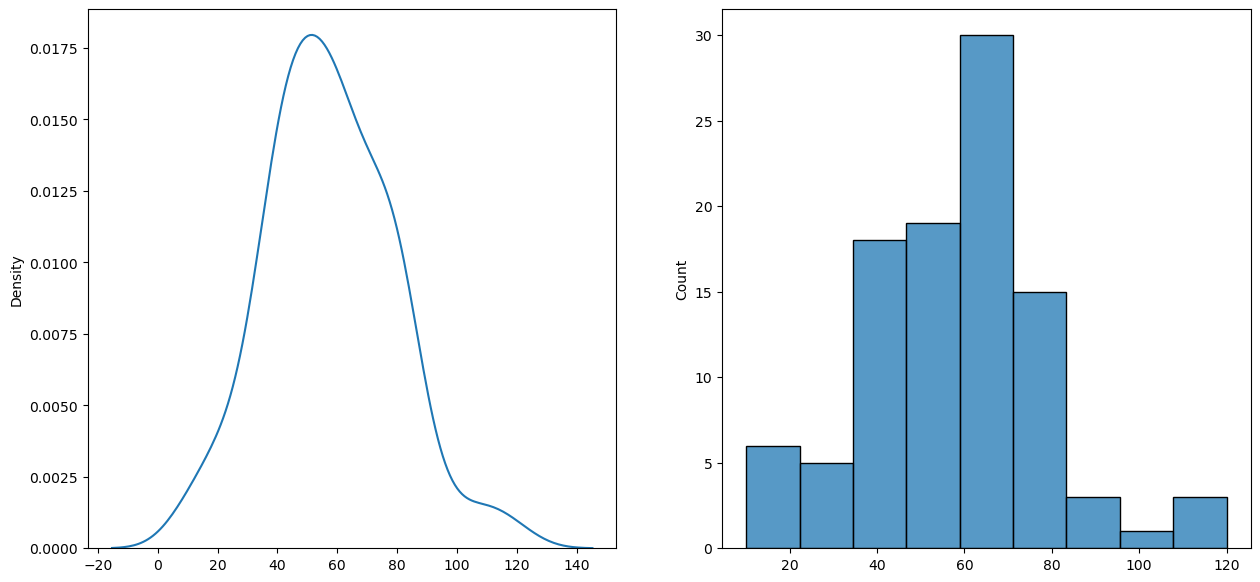

In [20]:
d, k = 10, 0
n_iter = 1000
x = 100
#run x amount of times
conditioning = False
random_rounding = False
rounding_freq = -1
proj_strength = 1
steps_taken_list, num_unfinished = big_test(d, k, n_iter, x, rounding_freq, conditioning, random_rounding, proj_strength)
print("avg steps", np.mean(steps_taken_list))
print("unfinished", num_unfinished/x*100, "%")

fig, ax = plt.subplots(1, 2, figsize=(15,7))
#make a 1 by 2 array of axis, put them in the fig object (of size 10 x 5 inches? pixels? )
#ax is the list of axis

#rounding is what gets you stuck in loops!!

sns.kdeplot(x=steps_taken_list, ax=ax[0])
sns.histplot(x=steps_taken_list, ax=ax[1])


 



In [11]:
#RUN A BUNCH OF BIG TESTS DIFF ROUNDING FREQ
"""
d, k = 15, 2
n_iter = 1000
x = 100
#run x amount of times
conditioning = False
random_rounding = False
freq_to_test = [-1, 0.1, 0.2, 0.5, 1]
proj_strength = 1


for i in range(len(freq_to_test)):
    print("freq", freq_to_test[i])
    big_test(d, k, n_iter, x, freq_to_test[i], False, random_rounding, proj_strength)
    print("WITH CONDITIONING")
    big_test(d, k, n_iter, x, freq_to_test[i], True, random_rounding, proj_strength)
    print("")
"""

freq -1
WITH CONDITIONING

freq 0.1
WITH CONDITIONING

freq 0.2
WITH CONDITIONING

freq 0.5
WITH CONDITIONING

freq 1
WITH CONDITIONING



#QUESTIONS:
CONDITIONING???


  i = np.random.choice(d) -  picks a random number from a 1D array created like np.arange(d)?

#THINGS TO IMPLEMENT

making rounding a probability instead of modulo

randomness in general helps us get stuck in a loop (for the runs that just don't finish)




#IDEAS:
Matrix Conditioning

Adding noise per vector projection 

Rounding freq
  - making it a probability instead of %

Normalize vectors on each step

Adaptive rounding?
  - if you've moved a small amount, probability to round is smaller
     - measure distance projected norm of distance between new and old vector
  - we only round if it brings us to a novel sign vector
Projecting somewhere else onto the orthogonal subspace instead of the shortest possible path



In [12]:

""

''